<a href="https://colab.research.google.com/github/AtSourav/CatsnDogs_VAE/blob/main/MNIST_beta1_noreg_l10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Defining the model**

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow import keras       # cannot use the name tf to import modules, can only use it to call functions or modules
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras.datasets import mnist

import os
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import matplotlib.animation as animation


In [2]:
input_size = (14,14,1)
latent_dim = 10
batch_size = 64


In [3]:
(img_train, tg_train), (img_valid, tg_valid) = mnist.load_data()

img_ht = img_train.shape[1]         #the shape of the data is (count, ht, wd)
img_wd = img_train.shape[2]
count_train = img_train.shape[0]
count_valid = img_valid.shape[0]

img_train = img_train.reshape(count_train,img_ht,img_wd, 1)     # we are adding the channel axis manually
img_valid = img_valid.reshape(count_valid,img_ht,img_wd, 1)

print(img_train.shape)
print(img_valid.shape)

11490434/11490434 [==============================] - 1s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [4]:
img_train = layers.Resizing(14, 14, interpolation="bilinear")(img_train)
img_valid = layers.Resizing(14, 14, interpolation="bilinear")(img_valid)

img_train = img_train/255.
img_valid = img_valid/255.

print(img_train.shape)
print(img_valid.shape)


(60000, 14, 14, 1)
(10000, 14, 14, 1)


In [5]:
l2_reg = keras.regularizers.L2(l2=0.001)

In [5]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(10, 2, padding="valid")(encoder_input)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="same")(x)    # with strides=None this defaults to pool_size
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x) # the default data_format in the conv2d is "channels last", we want to normalize across the channels, hence we set axis=-1
x = layers.ReLU()(x)

x = layers.Conv2D(30, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding="valid")(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(50, 2, padding="valid")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

#x = layers.Dense(8*latent_dim)(x)
x = layers.Dense(2*latent_dim)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sampling(arg):
  z_m, z_log_v = arg
  batch = tf.shape(z_m)[0]
  dim = tf.shape(z_m)[1]
  eps = tf.random.normal(shape=(batch,dim))
  return z_m + tf.exp(0.5*z_log_v)*eps

z = layers.Lambda(sampling)([z_mean,z_log_var])   # we feed the sampling function in to a Lambda layer to build form a layer for the architecture as keras needs

encoder = keras.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')           # the second argument specifies that the encoder outputs [z_mean, z_log_var, z] for each input.
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 14, 14, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 13, 13, 10)           50        ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 7, 7, 10)             0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 re_lu (ReLU)                (None, 7, 7, 10)             0         ['max_pooling2d[0][0]'] 

In [6]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x
                  )
x = layers.Dense(30)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Dense(50)(x)
# = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Reshape((1,1,50))(x)

x = layers.Conv2DTranspose(30, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.001)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(20, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(10, 2, strides=2, padding='same')(x)
#x = layers.SpatialDropout2D(0.01)(x)
#x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding="valid")(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(1, 2, activation='sigmoid', strides=2, padding='same')(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_1 (Dense)             (None, 20)                220       
                                                                 
 re_lu_4 (ReLU)              (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 30)                630       
                                                                 
 re_lu_5 (ReLU)              (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 50)                1550      
                                                                 
 re_lu_6 (ReLU)              (None, 50)                0   

Now let's instantiate the VAE by combininb the encoder and the decoder layers.

In [7]:
decoder_out = decoder(encoder(encoder_input)[2])          # we feed in z from the encoder output
VAE = keras.Model(encoder_input, decoder_out, name='VAE')

VAE.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 14, 14, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 10),              8770      
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 decoder (Functional)        (None, 14, 14, 1)         11701     
                                                                 
Total params: 20471 (79.96 KB)
Trainable params: 20471 (79.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We shall define the loss function now, it's made of the reconstruction loss that tries to ensure repoducibility of the data, and the KL divergence loss that tries to ensure that the learned (approximate) posterior is close to the true posterior.

We shall keep a relative weight beta between the two terms in the total loss as a hyperparameter. We may want to investigate the effects of varying this hyperparameter eventually.

In [8]:
beta = 1  # we shall vary this later

def vae_loss(true,pred):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(losses.binary_crossentropy(true,pred), axis=(1,2) ))

  z_m = encoder(true)[0]
  z_l_v = encoder(true)[1]

  kl_div = tf.reduce_mean(tf.reduce_sum(-0.5*(1 + z_l_v - tf.square(z_m) - tf.exp(z_l_v)),1), -1)

  return reconstruction_loss + beta*kl_div

In [9]:
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001, decay_steps=10000000, decay_rate=0.99, staircase=True)
optim = keras.optimizers.Adam(learning_rate = 0.001)
VAE.compile(optimizer=optim,loss=vae_loss)

# **Running up to 15 epochs**

In [10]:
history = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)


Epoch 1/15
938/938 [==============================] - 38s 31ms/step - loss: 56.4387 - val_loss: 50.3130
Epoch 2/15
938/938 [==============================] - 23s 25ms/step - loss: 49.5927 - val_loss: 49.0727
Epoch 3/15
938/938 [==============================] - 26s 28ms/step - loss: 48.9292 - val_loss: 48.6161
Epoch 4/15
938/938 [==============================] - 25s 27ms/step - loss: 48.4349 - val_loss: 47.8863
Epoch 5/15
938/938 [==============================] - 26s 27ms/step - loss: 47.6437 - val_loss: 47.1057
Epoch 6/15
938/938 [==============================] - 26s 28ms/step - loss: 46.2189 - val_loss: 45.5066
Epoch 7/15
938/938 [==============================] - 25s 26ms/step - loss: 45.2738 - val_loss: 45.0931
Epoch 8/15
938/938 [==============================] - 25s 26ms/step - loss: 44.8240 - val_loss: 44.9072
Epoch 9/15
938/938 [==============================] - 25s 26ms/step - loss: 44.5578 - val_loss: 44.5010
Epoch 10/15
938/938 [==============================] - 24s 26ms/

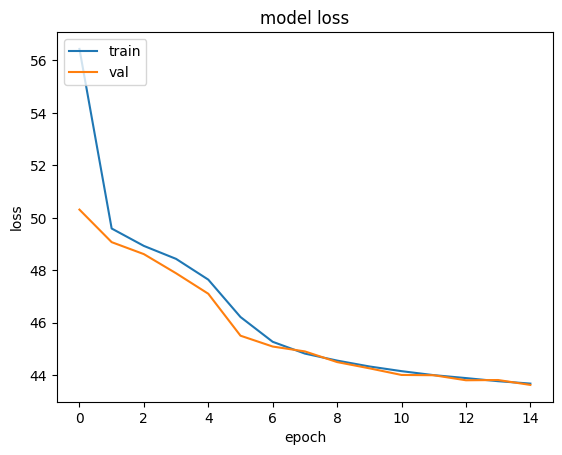

In [11]:
plt.plot(history.history['loss'])         # history.history is a dict with performance metrics as keys
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model is still undertrained, which is a little strange considering there's no regularisation in the encoder/decoder, probably has to do with beta being 1, might need to lower it to overtrain.

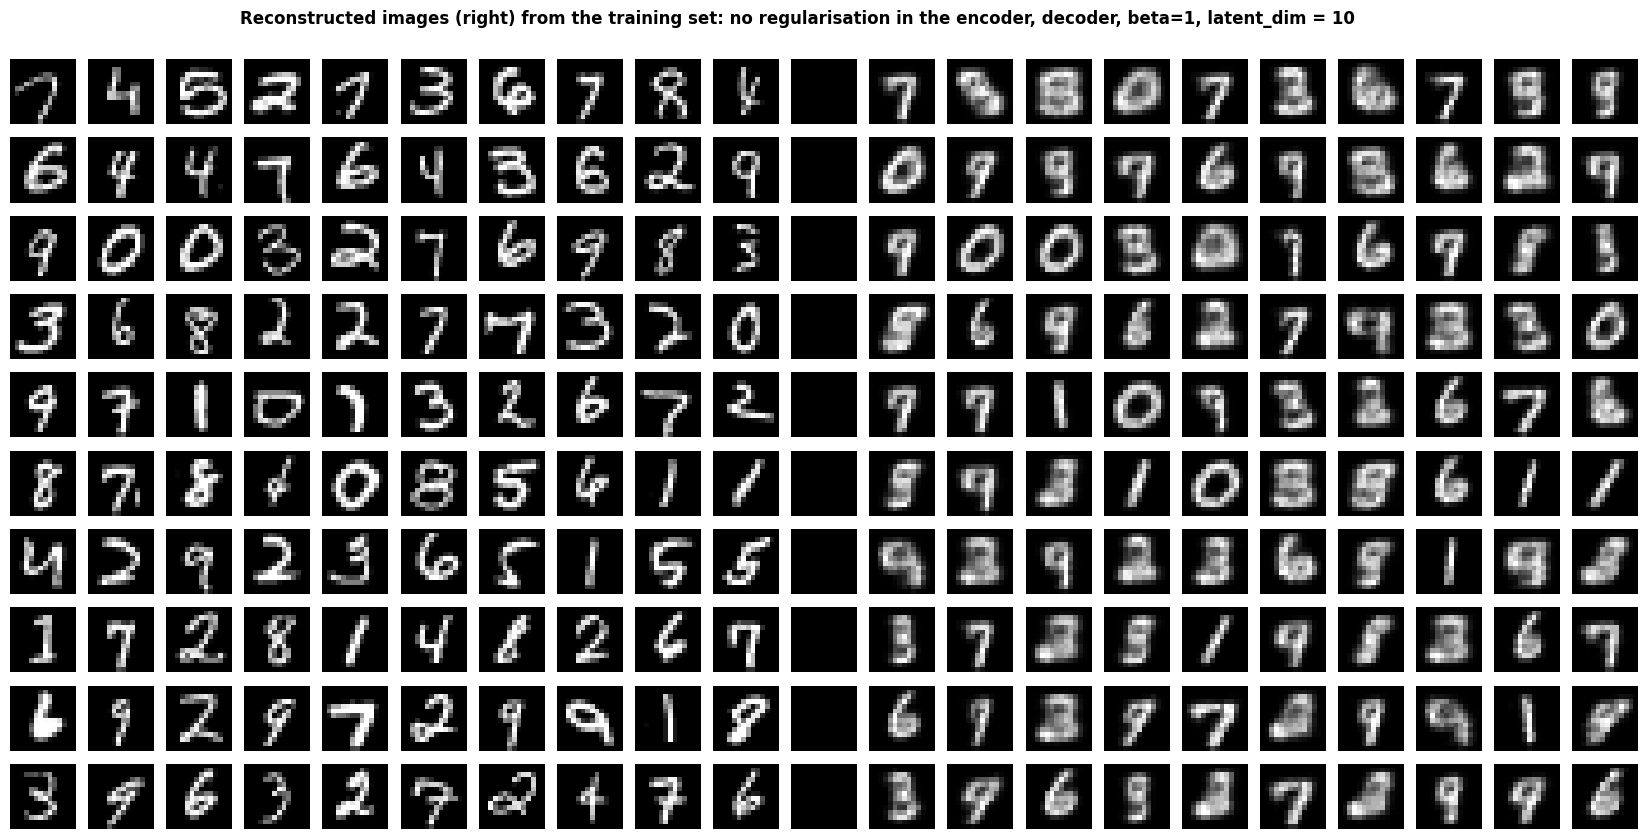

In [22]:
np.random.seed(111)

tr_tg_indices = np.random.randint(0,60000,size = 100)
img_train_sample = tf.convert_to_tensor(np.array(img_train)[tr_tg_indices])
_,_,z_train_sample = encoder(img_train_sample)
img_recon_train = decoder(z_train_sample)

digits_train_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_train_recon.suptitle('Reconstructed images (right) from the training set after 15 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_train_recon.tight_layout()

for i in range(210):
  digits_train_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_train[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')




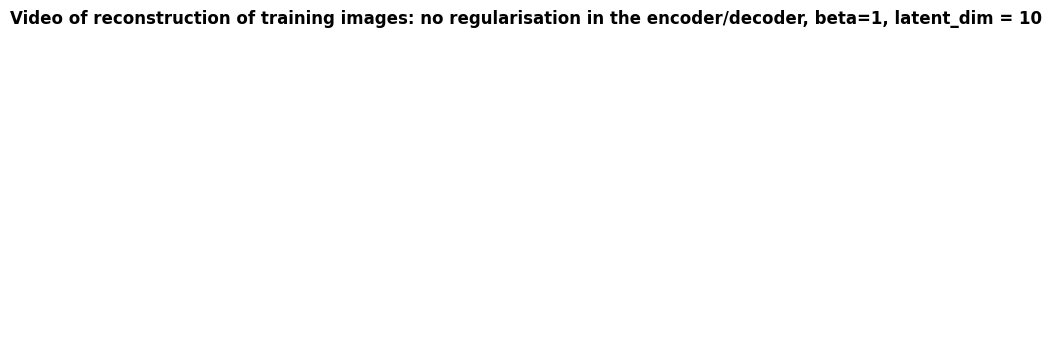

In [28]:
# colab doesn't display the mp4 video

concat_train = tf.concat([img_train_sample, img_recon_train],2)     # to put the original image and the reconstruction next to each other into a (14,28,1) image

frames = []

concat_recon_vid = plt.figure(figsize=(3,6))
plt.axis('off')
concat_recon_vid.suptitle('Video of reconstruction of training images: no regularisation in the encoder/decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

for i in range(25):
    frames.append([plt.imshow(concat_train[i], animated=True)])

vid = animation.ArtistAnimation(concat_recon_vid, frames, interval=50, blit=True,
                                repeat_delay=1000)
# vid.save('recon_train_vid.mp4')
plt.show()


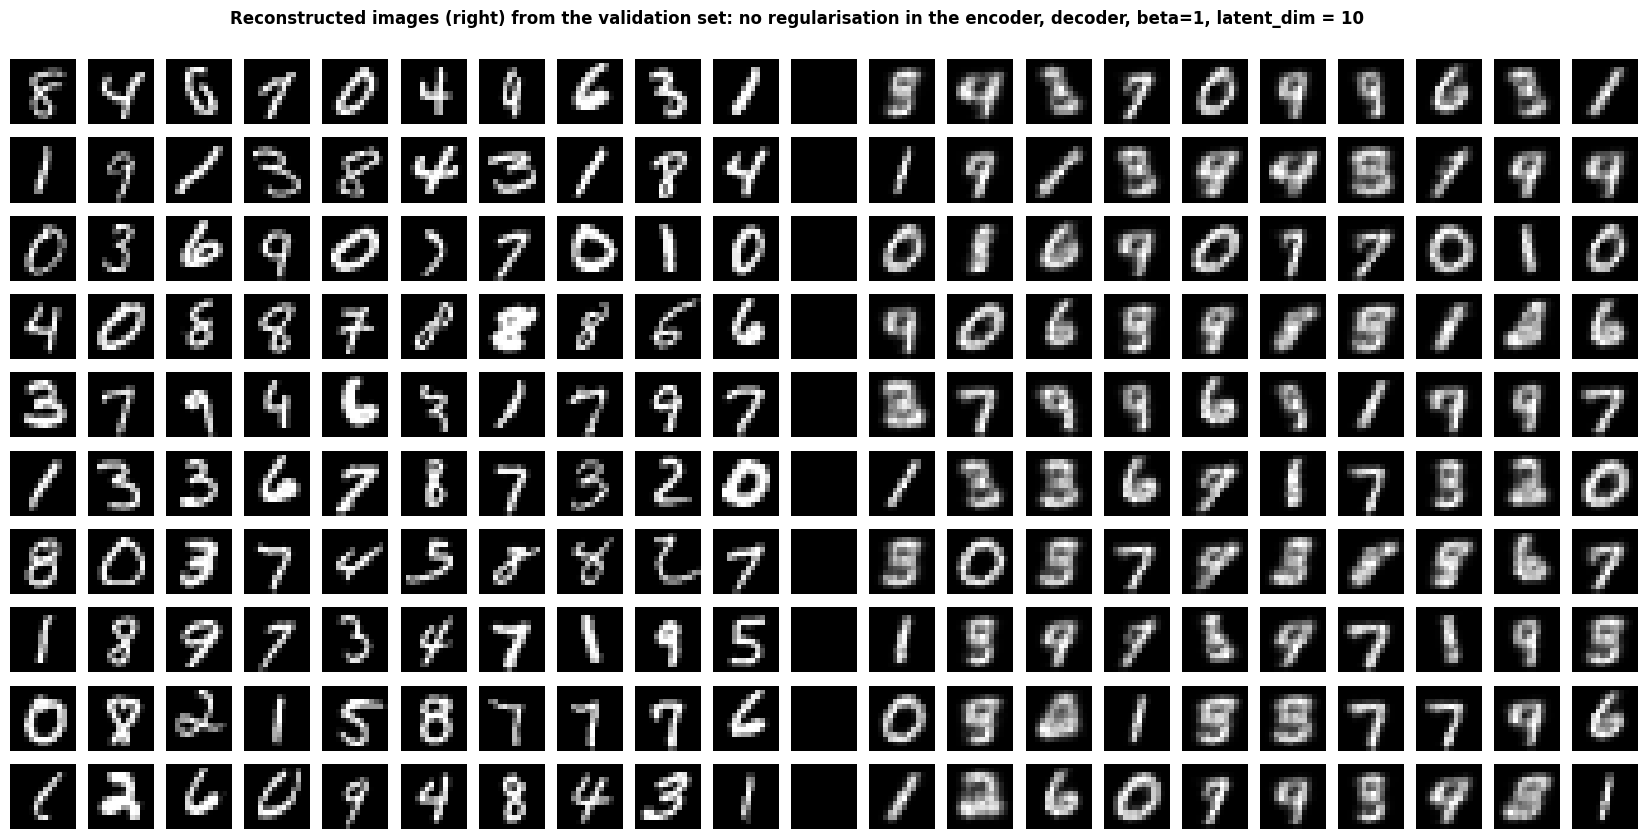

In [23]:
np.random.seed(14)

va_tg_indices = np.random.randint(0,10000,size = 100)
img_valid_sample = tf.convert_to_tensor(np.array(img_valid)[va_tg_indices])
_,_,z_valid_sample = encoder(img_valid_sample)
img_recon_valid = decoder(z_valid_sample)

digits_valid_recon = plt.figure(figsize=(21,10))

digits_valid_recon.suptitle('Reconstructed images (right) from the validation set after 15 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_valid_recon.tight_layout()

for i in range(210):
  digits_valid_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_valid[va_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_valid[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')


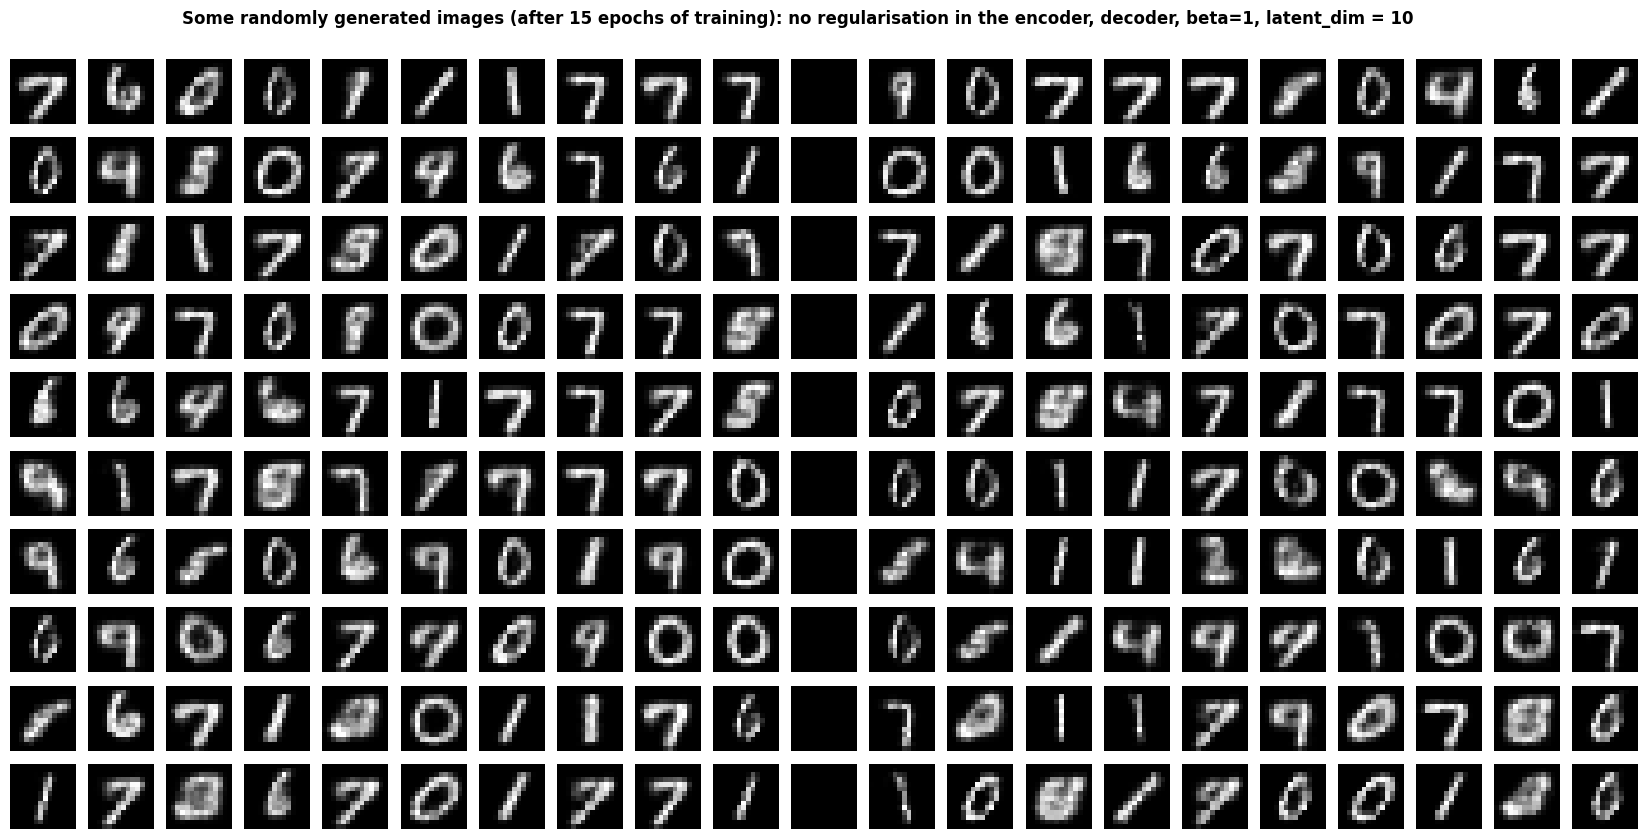

In [38]:
np.random.seed(100)

min_train = min(K.flatten(z_train_sample))
max_train = max(K.flatten(z_train_sample))

min_valid = min(K.flatten(z_valid_sample))
max_valid = max(K.flatten(z_valid_sample))



z_rand_train = tf.convert_to_tensor(min_train + (max_train-min_train)*np.random.random((100,10)))
z_rand_valid = tf.convert_to_tensor(min_valid + (max_valid-min_valid)*np.random.random((100,10)))

img_rand_recon_tr = decoder(z_rand_train)
img_rand_recon_va = decoder(z_rand_valid)

digits_rand_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_rand_recon.suptitle('Some randomly generated images (after 15 epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


for i in range(210):
  digits_rand_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_rand_recon_tr[j*10 + (i%21)]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_rand_recon_va[j*10 + (i%21) - 12]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

# **Running further to try and overtrain**

In [29]:
history2 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)      #running further from where we left off at 15 epochs


Epoch 1/15
938/938 [==============================] - 27s 28ms/step - loss: 43.6036 - val_loss: 43.6396
Epoch 2/15
938/938 [==============================] - 25s 26ms/step - loss: 43.5280 - val_loss: 43.3788
Epoch 3/15
938/938 [==============================] - 25s 26ms/step - loss: 43.4677 - val_loss: 43.3933
Epoch 4/15
938/938 [==============================] - 25s 27ms/step - loss: 43.3845 - val_loss: 43.3805
Epoch 5/15
938/938 [==============================] - 24s 26ms/step - loss: 43.3466 - val_loss: 43.5337
Epoch 6/15
938/938 [==============================] - 24s 26ms/step - loss: 43.2994 - val_loss: 43.2692
Epoch 7/15
938/938 [==============================] - 26s 28ms/step - loss: 43.2428 - val_loss: 43.1615
Epoch 8/15
938/938 [==============================] - 26s 28ms/step - loss: 43.2052 - val_loss: 43.1134
Epoch 9/15
938/938 [==============================] - 26s 28ms/step - loss: 43.1509 - val_loss: 43.0882
Epoch 10/15
938/938 [==============================] - 26s 28ms/

In [30]:
history3 = VAE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)      #it's barely overfitting now, so running it for 10 more epochs

Epoch 1/10
938/938 [==============================] - 26s 28ms/step - loss: 42.9151 - val_loss: 43.0426
Epoch 2/10
938/938 [==============================] - 25s 26ms/step - loss: 42.8815 - val_loss: 42.7197
Epoch 3/10
938/938 [==============================] - 25s 27ms/step - loss: 42.8657 - val_loss: 42.7080
Epoch 4/10
938/938 [==============================] - 25s 26ms/step - loss: 42.8399 - val_loss: 42.8840
Epoch 5/10
938/938 [==============================] - 25s 27ms/step - loss: 42.8258 - val_loss: 42.9060
Epoch 6/10
938/938 [==============================] - 26s 28ms/step - loss: 42.7859 - val_loss: 42.7605
Epoch 7/10
938/938 [==============================] - 25s 26ms/step - loss: 42.7643 - val_loss: 42.6385
Epoch 8/10
938/938 [==============================] - 25s 26ms/step - loss: 42.7217 - val_loss: 42.6797
Epoch 9/10
938/938 [==============================] - 25s 27ms/step - loss: 42.7118 - val_loss: 42.6804
Epoch 10/10
938/938 [==============================] - 24s 25ms/

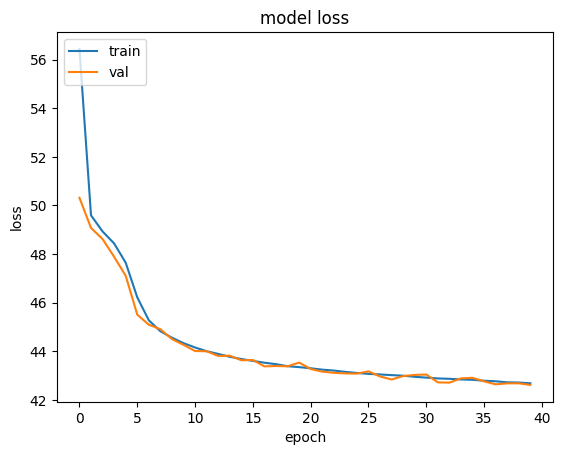

In [36]:
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'])         # we want to plot the enture learning history so far
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

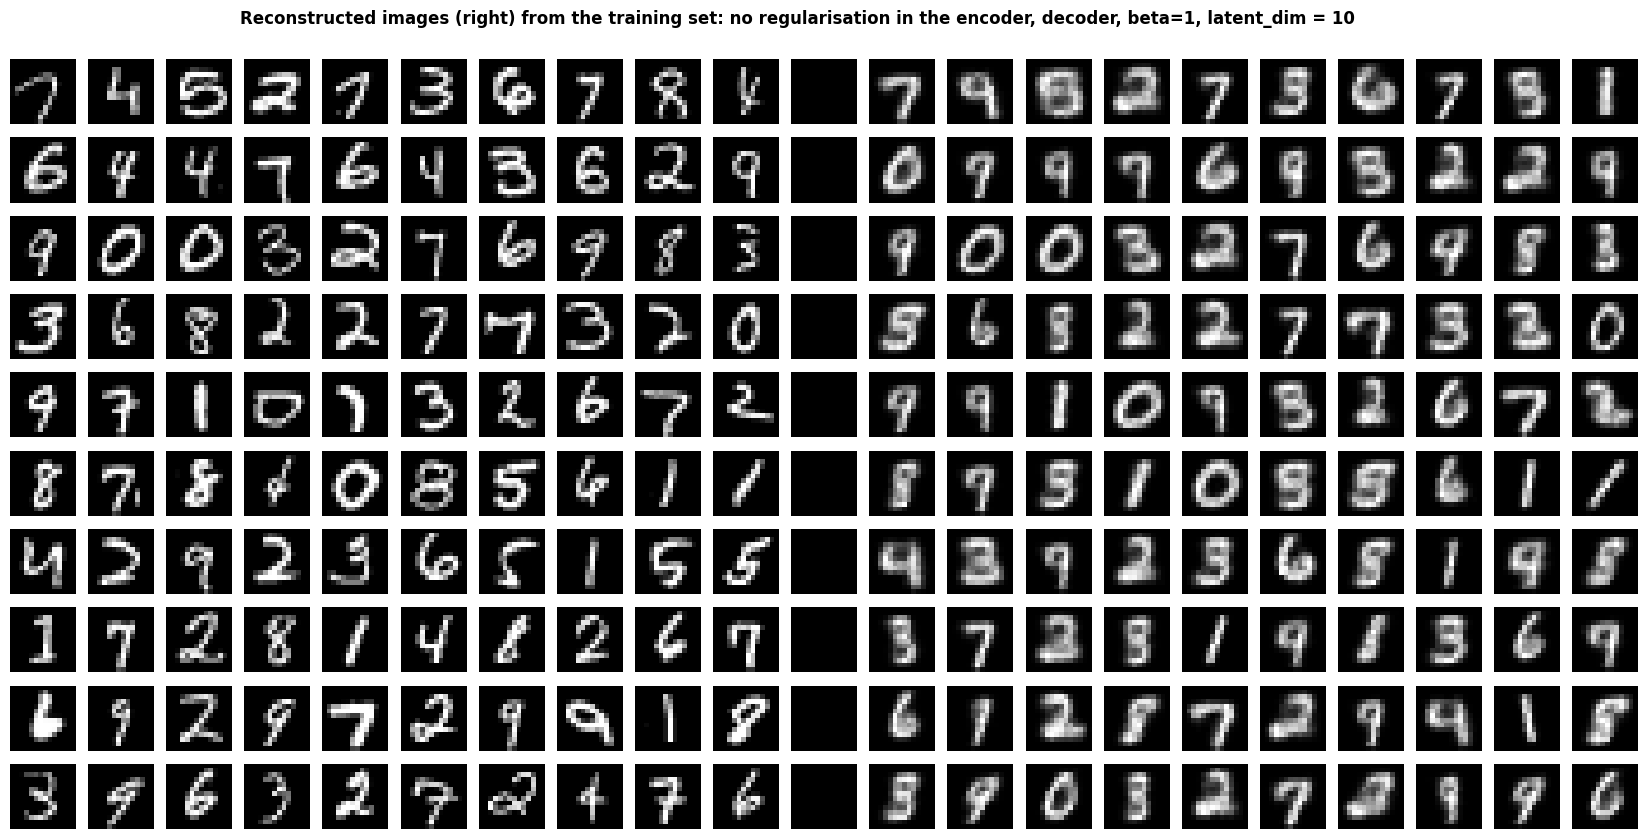

In [37]:
_,_,z_train_sample = encoder(img_train_sample)
img_recon_train = decoder(z_train_sample)

digits_train_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_train_recon.suptitle('Reconstructed images (right) from the training set after 40 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_train_recon.tight_layout()

for i in range(210):
  digits_train_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_train[tr_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_train[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

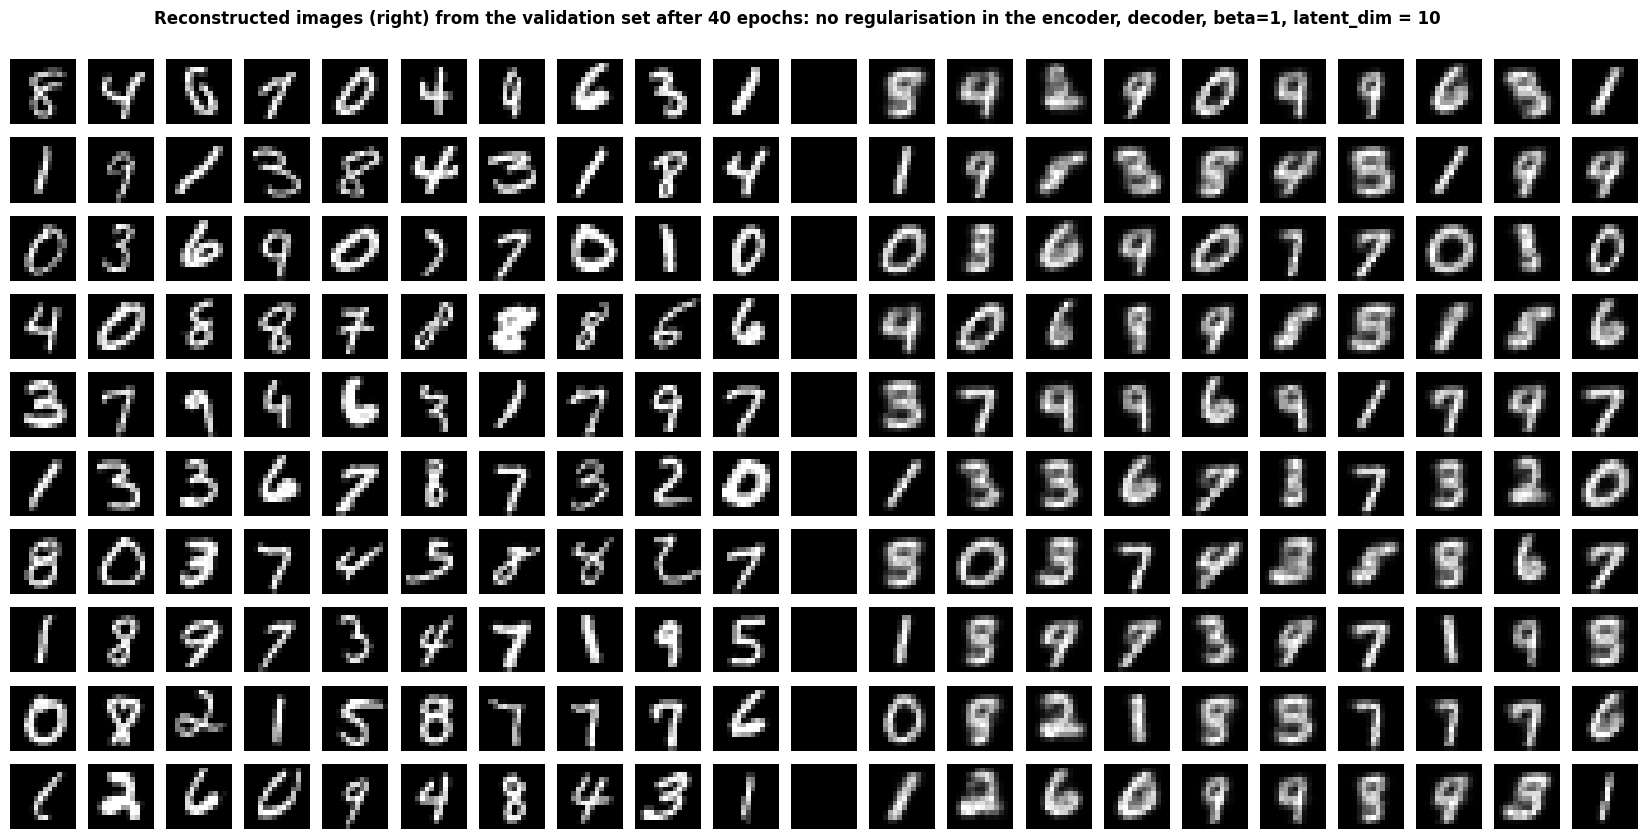

In [39]:
_,_,z_valid_sample = encoder(img_valid_sample)
img_recon_valid = decoder(z_valid_sample)

digits_valid_recon = plt.figure(figsize=(21,10))

digits_valid_recon.suptitle('Reconstructed images (right) from the validation set after 40 epochs: no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)

digits_valid_recon.tight_layout()

for i in range(210):
  digits_valid_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_valid[va_tg_indices[j*10 + (i%21)]]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_recon_valid[j*10 + (i%21) - 11]
    plt.imshow(img, cmap='gray')
    plt.axis('off')

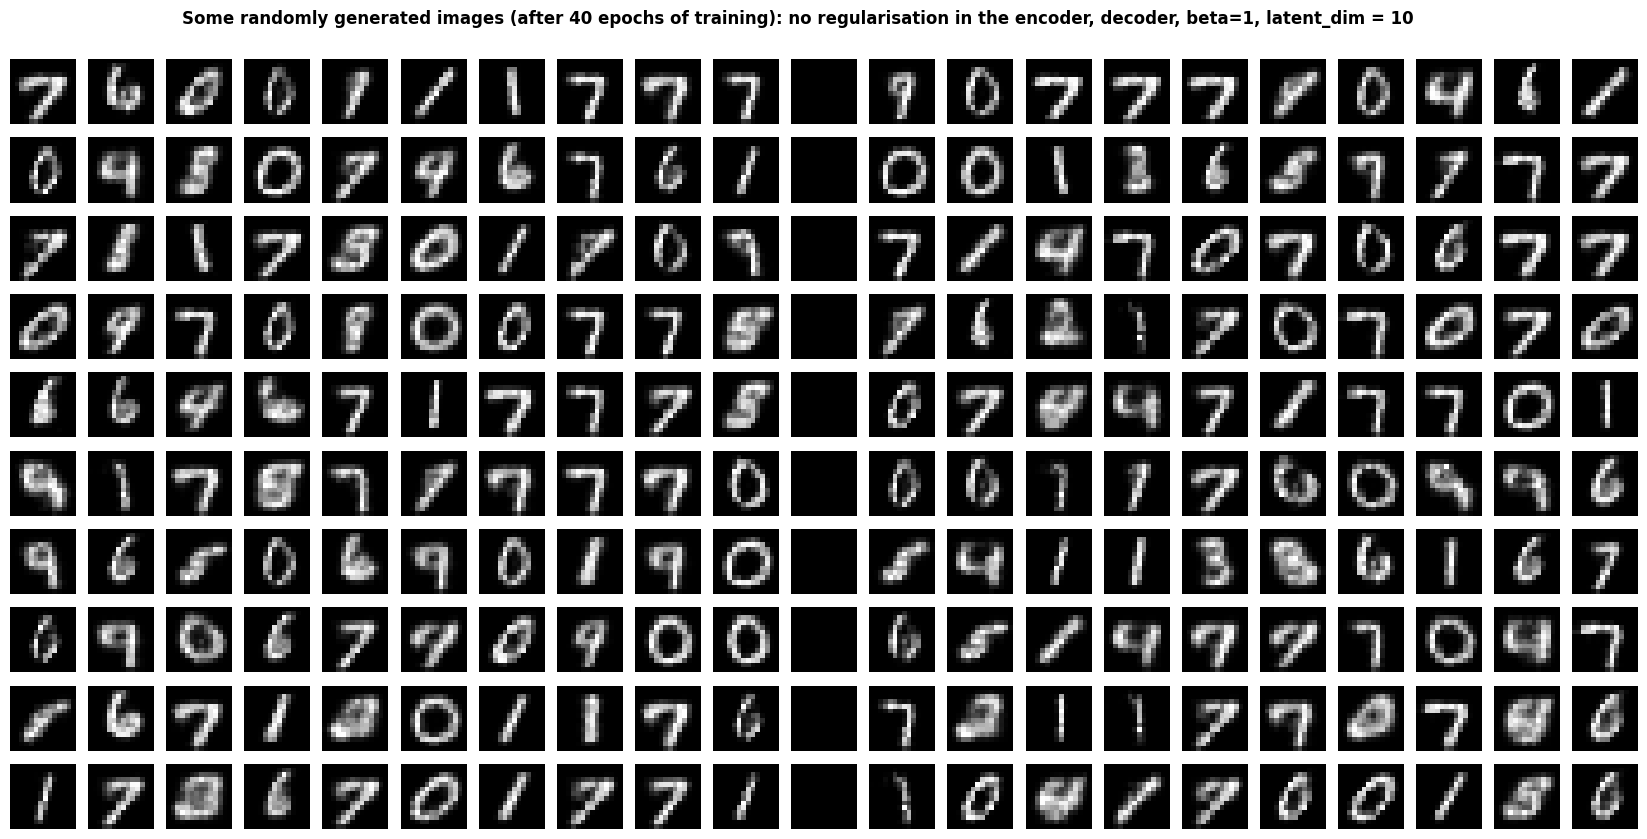

In [41]:
np.random.seed(100)

min_train = min(K.flatten(z_train_sample))
max_train = max(K.flatten(z_train_sample))

min_valid = min(K.flatten(z_valid_sample))
max_valid = max(K.flatten(z_valid_sample))



z_rand_train = tf.convert_to_tensor(min_train + (max_train-min_train)*np.random.random((100,10)))
z_rand_valid = tf.convert_to_tensor(min_valid + (max_valid-min_valid)*np.random.random((100,10)))

img_rand_recon_tr = decoder(z_rand_train)
img_rand_recon_va = decoder(z_rand_valid)

digits_rand_recon = plt.figure(figsize=(21,10))    # we leave one column of difference between the 10x10 grid of training images and 10x10 of validation images
                                        # it's weird that the order of axes in figsize is the opposite to that in add_subplot
digits_rand_recon.suptitle('Some randomly generated images (after 40 epochs of training): no regularisation in the encoder, decoder, beta=1, latent_dim = 10', fontweight= 'bold', y=0.93)


for i in range(210):
  digits_rand_recon.add_subplot(10,21,i+1)
  j = int(np.floor(i/21))
  if (i%21) <10:
    img = img_rand_recon_tr[j*10 + (i%21)]
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  elif (i%21)==10:
    img = np.ones((14,14,1))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
  else:
    img = img_rand_recon_va[j*10 + (i%21) - 12]
    plt.imshow(img, cmap='gray')
    plt.axis('off')